## Data Set

http://archive.ics.uci.edu/ml/datasets/statlog+(australian+credit+approval)

#### Data Set Information:

This file concerns credit card applications. All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data. 

This dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values. There are also a few missing values. 


#### Attribute Information:

There are 6 numerical and 8 categorical attributes. The labels have been changed for the convenience of the statistical algorithms. For example, attribute 4 originally had 3 labels p,g,gg and these have been changed to labels 1,2,3. 

- A1: 0,1 CATEGORICAL (formerly: a,b) 
- A2: continuous. 
- A3: continuous. 
- A4: 1,2,3 CATEGORICAL (formerly: p,g,gg) 
- A5: 1, 2,3,4,5, 6,7,8,9,10,11,12,13,14 CATEGORICAL (formerly: ff,d,i,k,j,aa,m,c,w, e, q, r,cc, x) 
- A6: 1, 2,3, 4,5,6,7,8,9 CATEGORICAL (formerly: ff,dd,j,bb,v,n,o,h,z) 
- A7: continuous. 
- A8: 1, 0 CATEGORICAL (formerly: t, f) 
- A9: 1, 0	CATEGORICAL (formerly: t, f) 
- A10: continuous. 
- A11: 1, 0	CATEGORICAL (formerly t, f) 
- A12: 1, 2, 3 CATEGORICAL (formerly: s, g, p) 
- A13: continuous. 
- A14: continuous. 
- A15: 1,2 class attribute (formerly: +,-)

## SOM

### General imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Loading the data set

In [2]:
dataset = pd.read_csv('../Data/credit_card_applications.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:,  -1].values

In [3]:
dataset.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


### Feature scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

### Training the SOM

In [5]:
from minisom import MiniSom

som = MiniSom(x=10, y=10, input_len=15, sigma=1.0, learning_rate=0.5)
som.random_weights_init(X)
som.train_random(data=X, num_iteration=100)

### Map visualization

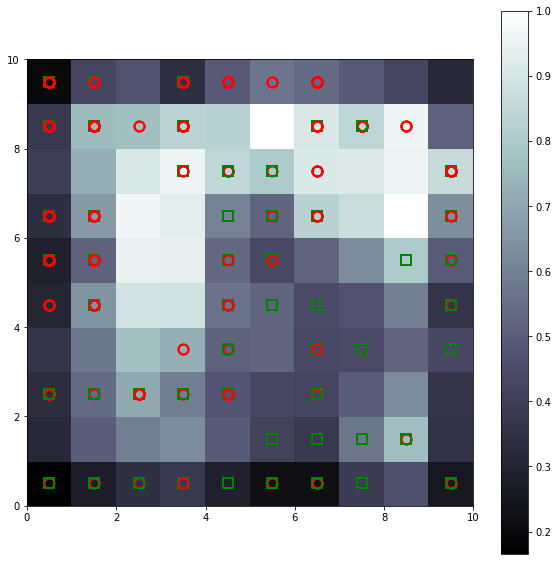

In [6]:
plt.figure(figsize=(10,10))
plt.bone()
plt.pcolor(som.distance_map().T)
plt.colorbar() # High risk of fraud
plt.axes().set_aspect('equal')

### True labels
markers = ['o', 's'] 
colors =  ['r', 'g'] # Didn't got approval vs. Got approval
for i, x in enumerate(X):
    w = som.winner(x) # Get winner node for each client
    plt.plot(w[0] + 0.5,
             w[1] + 0.5,
             markers[y[i]],
             markeredgecolor = colors[y[i]],
             markerfacecolor = 'None',
             markersize = 10,
             markeredgewidth = 2)
plt.show()

### Finding the frauds

In [8]:
mappings = som.win_map(X)
frauds = np.concatenate((mappings[(8,5)], mappings[(3,9)]), axis = 0) # Winning nodes with high risk of fraud
print(frauds.shape)
frauds = scaler.inverse_transform(frauds)

(17, 15)


## Artificial Neural Network

### Unsupervised to Supervised Learning

In [9]:
# Creating the matrix of features
customers = dataset.iloc[:, 1:].values

In [10]:
# Creating the dependent variable
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
    if dataset.iloc[i,0] in frauds:
        is_fraud[i] = 1

In [12]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
customers = scaler.fit_transform(customers)

### Keras Model

In [14]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [17]:
model = Sequential()
model.add(Dense(units=2, kernel_initializer='uniform', activation='relu', input_dim=15))
model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(customers, is_fraud, batch_size=1, epochs=2, validation_split=0.2)

Train on 552 samples, validate on 138 samples
Epoch 1/2
552/552 [==============================] - 3s - loss: 0.5082 - acc: 0.9728 - val_loss: 0.3452 - val_acc: 0.9783
Epoch 2/2
552/552 [==============================] - 2s - loss: 0.2486 - acc: 0.9746 - val_loss: 0.1817 - val_acc: 0.9783


In [22]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


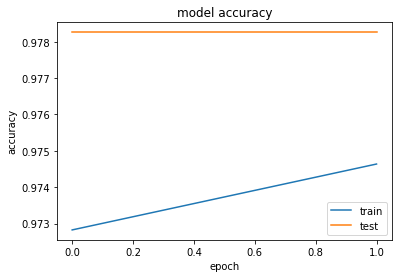

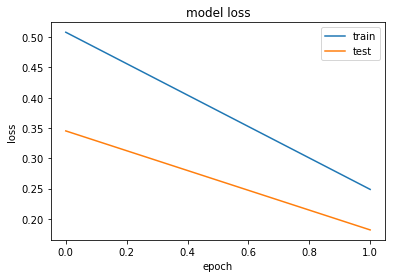

In [23]:
plot_history(history)

In [36]:
y_pred = model.predict(customers)
y_pred = np.concatenate((dataset.iloc[:, 0:1].values, y_pred), axis = 1)
y_pred = y_pred[y_pred[:, 1].argsort()]

In [39]:
import pandas as pd

pd.DataFrame(y_pred).head(20)

,0,1
0,15654859.0,0.004859
1,15725028.0,0.005673
2,15723827.0,0.006297
3,15731989.0,0.007810
4,15566495.0,0.007865
5,15585855.0,0.008683
6,15803378.0,0.009363
7,15764444.0,0.009420
8,15746995.0,0.010772
9,15667460.0,0.010982
